In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
# %matplotlib widget
import matplotlib.pyplot as plt
plt.style.use('./niceplot2jay.mplstyle')

import numpy as np
from utils_spctrm import *
from utils_folding import *
file = '/appalachia/d5/DISK/from_pleiades/snapshots/gmcs0_wind4_gmc9/snapshot_550.hdf5'

Only the CPU-only flavour of Voxelize is available!


In [ ]:
a = 1

In [ ]:
print(a)

In [2]:
simParticles = load_snapshot(file, remove_bulk_velocity=True, shift_to_origin=True)
simField3D = simParticles.interp_field(Nsize=128, smoothing_rate=1.) # Interpolate
spctrm0 = simField3D.spctrm() # Compute

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
root_add_process : started ...
workers_process : started ...
workers using 35 threads.
Workers processed 31576651 numbers, of which were
	0.000e+00 exact calculations (R<Rmin),
	2.821e+07 exact calculations (R>Rmax),
	3.364e+06 trivial calculations,
	0.000e+00 interpolations.

workers_process : ended.
Root processed 31576651 numbers in 983 CPU-chunks.
root_add_process : ended.
voxelize_gpu function took 3.8258 seconds
In the end, 0 in cpu_queue


Specific kinetic energy before FFT: 7.27e+04
Specific kinetic energy after FFT: 7.27e+04
Conserved quantity after sampling: 6.30e+04


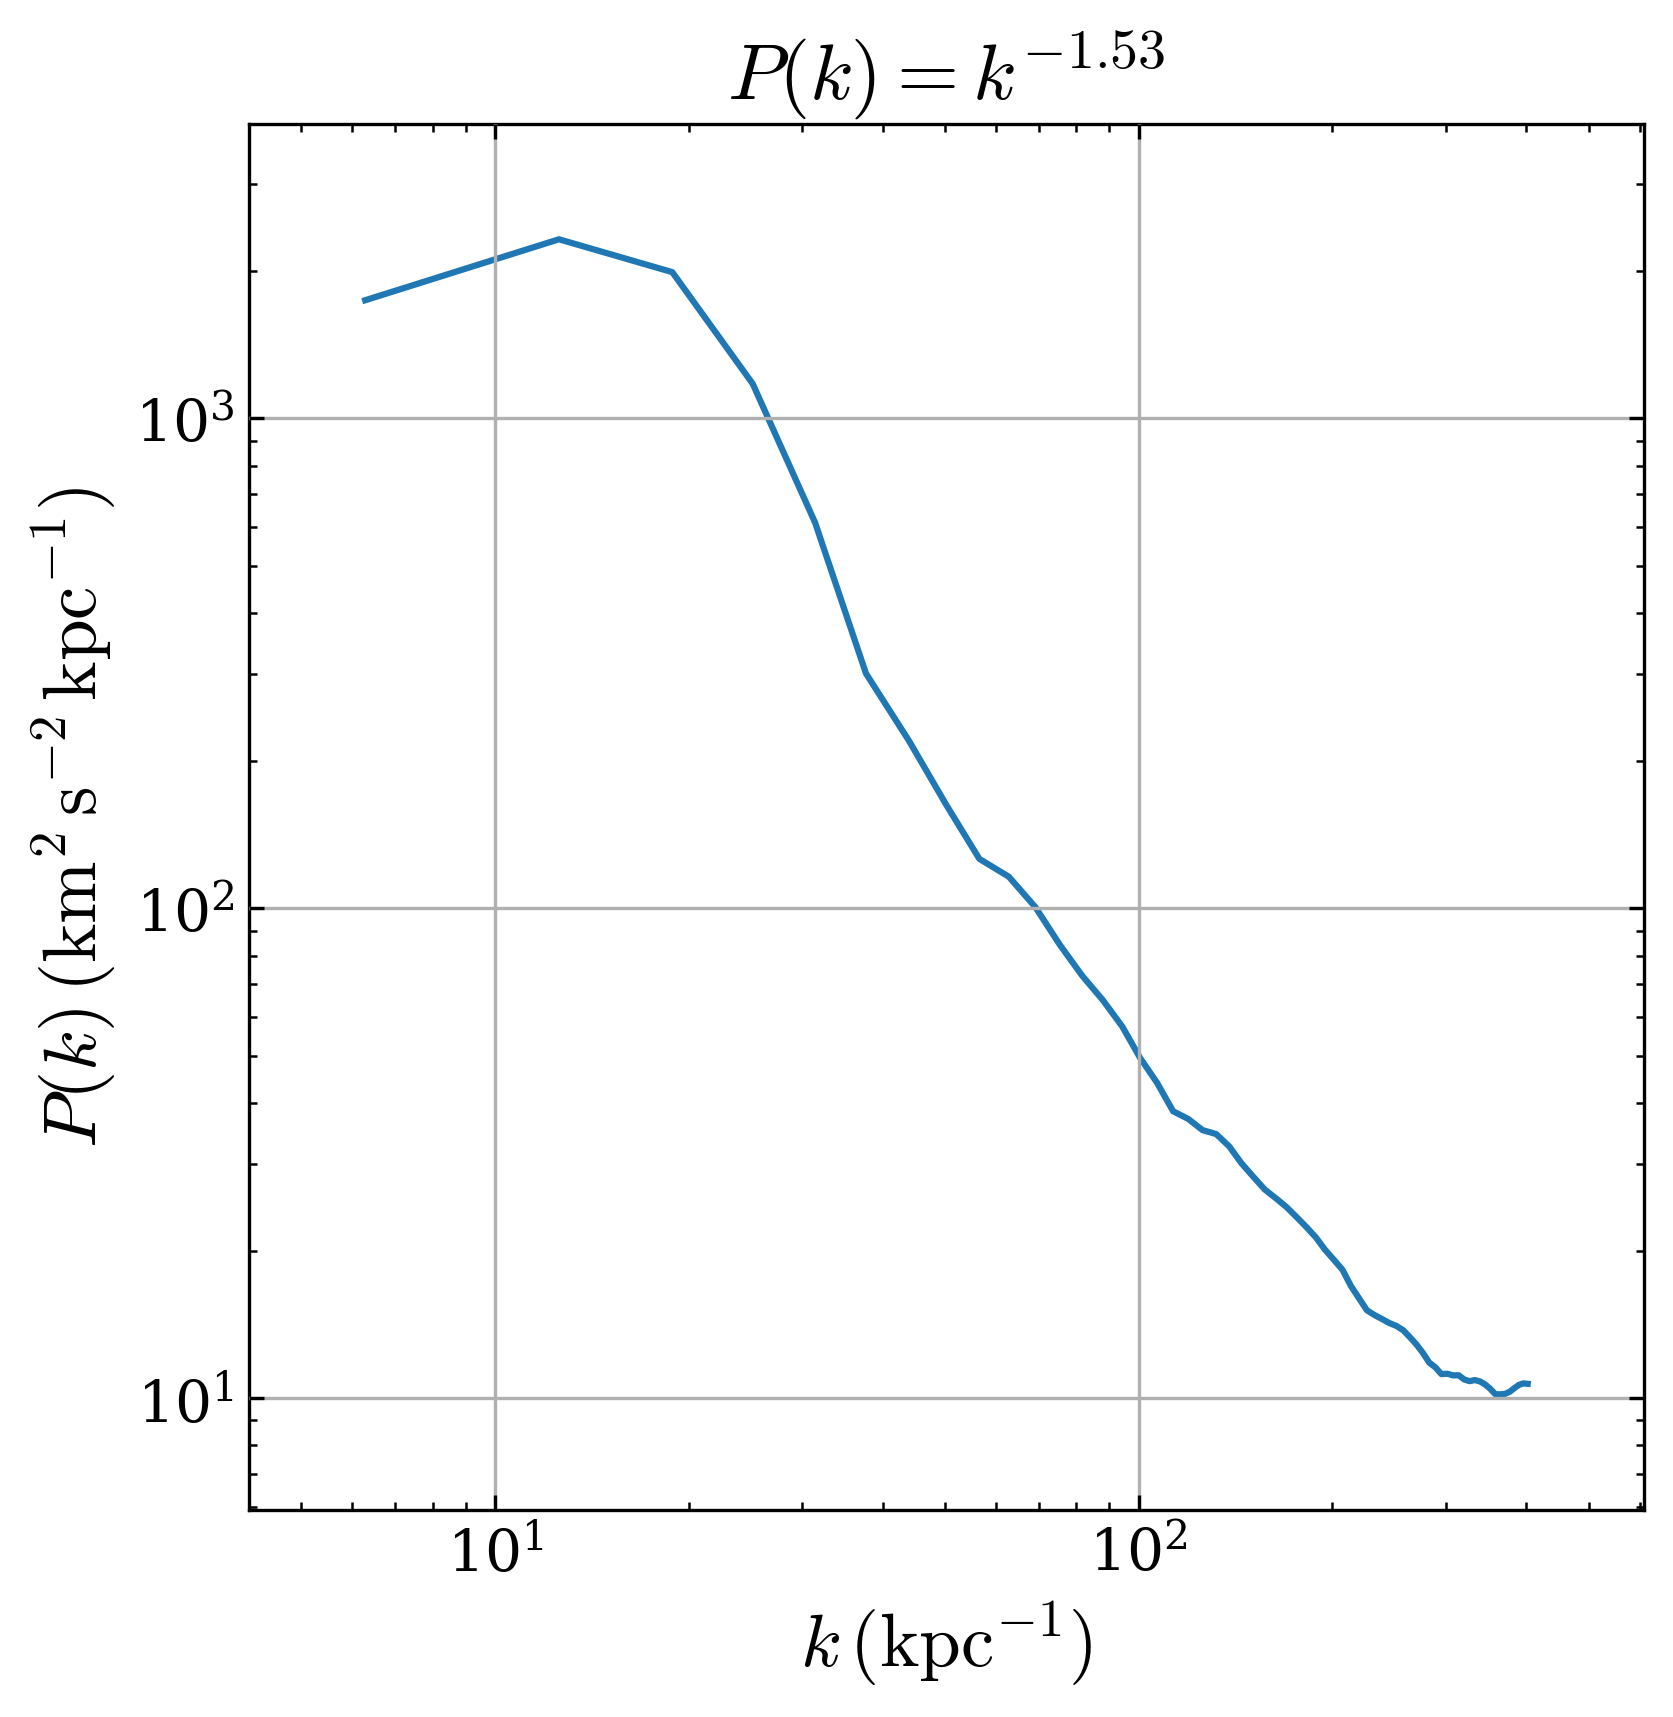

In [3]:
spctrm0.peek()

In [4]:
# Choose m and compute each folded spectrum
m = 8
spctrms = []
for betax in range(m):
  for betay in range(m):
    for betaz in range(m):
      beta = np.array([betax, betay, betaz])
      foldedField3D = simField3D.fold(m=m, beta=beta, quantity='velocity') # fold N^3 -> N^3/m^3
      pwrSpctrm = foldedField3D.fold_spctrm(beta=beta) # Compute
      spctrms.append(pwrSpctrm)

/appalachia/d6/yujie/Test_PowerSpec/utils_folding.py:630: RuntimeWarning: invalid value encountered in true_divide
  P = Psum/Nsample


In [5]:
# Explore the m space
# Combine the folded spectra
fullspctrm = spctrms[0].copy()
i = 0
for pwrSpctrm in spctrms:
  if i != 0:
    fullspctrm.add(spctrms[i])
  i += 1

/appalachia/d6/yujie/Test_PowerSpec/utils_spctrm.py:81: RuntimeWarning: invalid value encountered in true_divide
  self.P = self.Psum / self.Nsample * (4*np.pi*self.k**2)


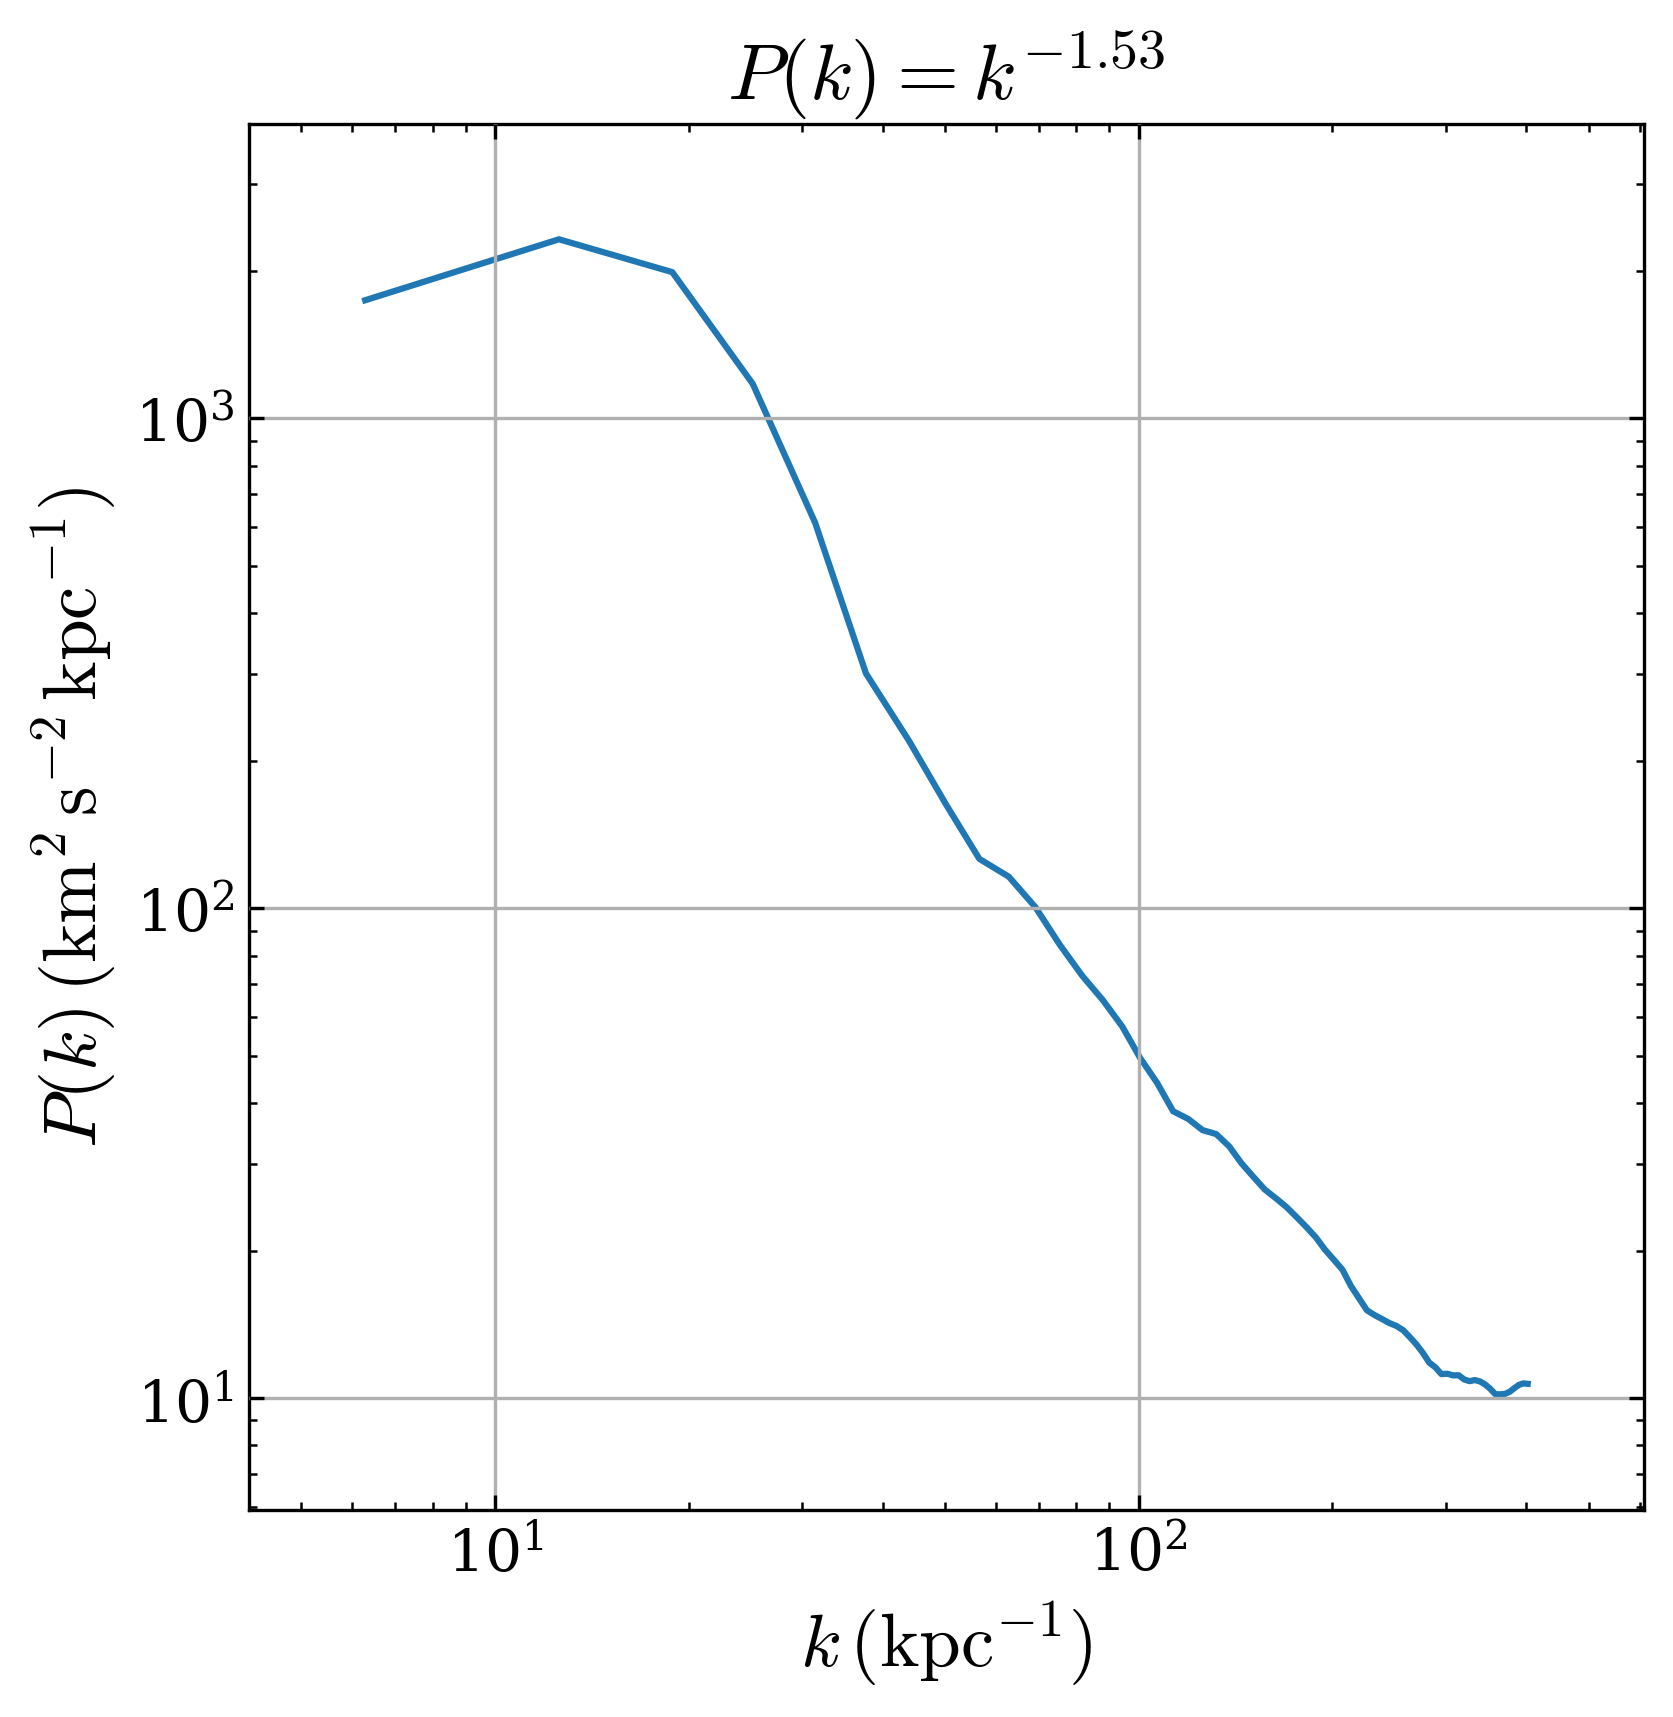

In [6]:
fullspctrm.peek()

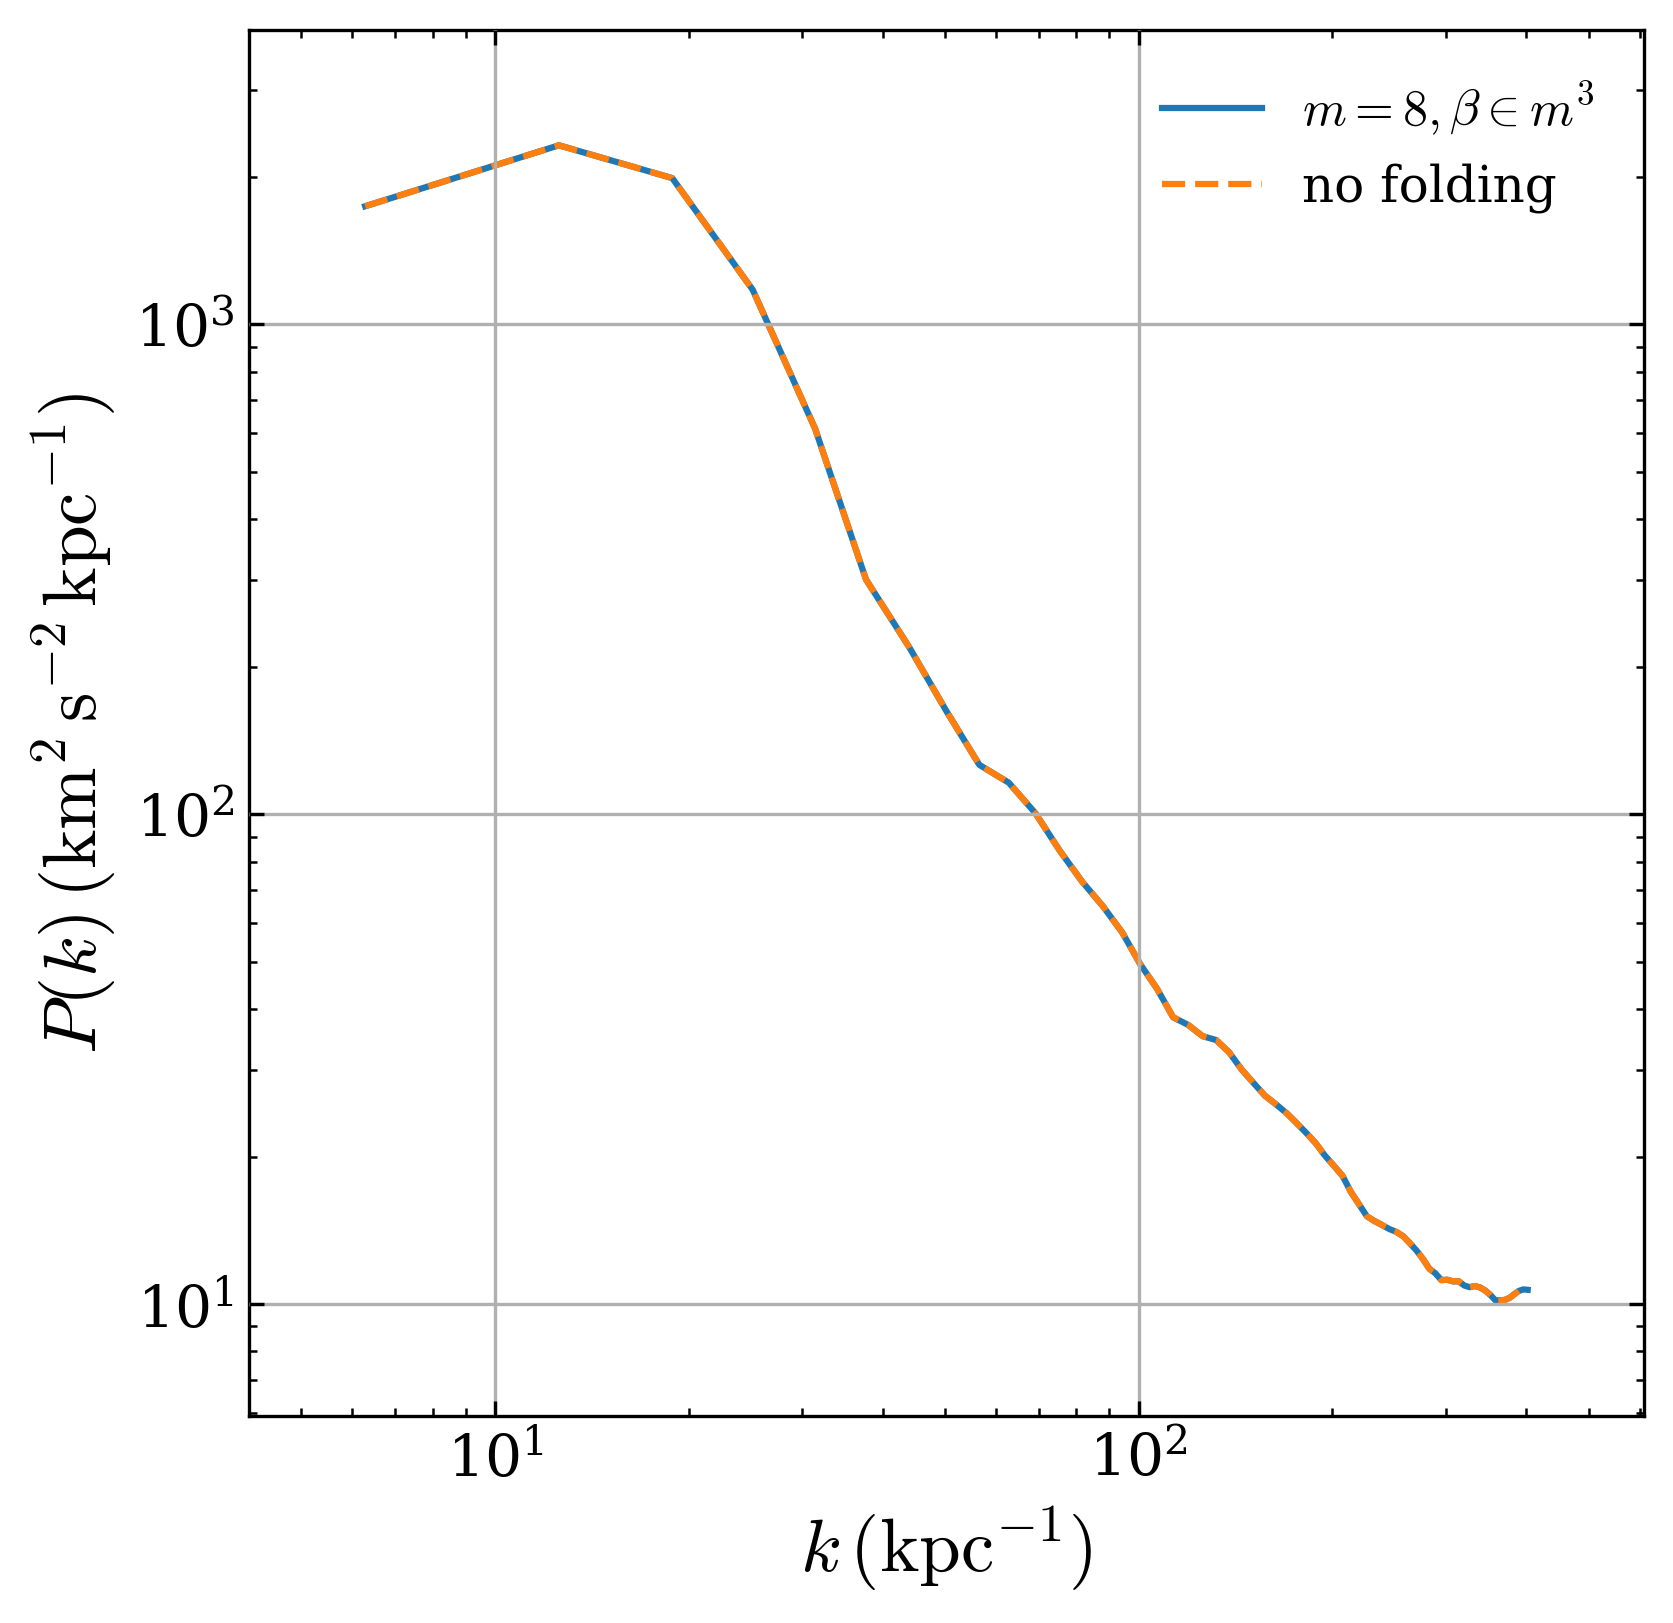

In [7]:
# Compare the full spectrum retored with the no folding case before
# running other tests.
fig, ax = plt.subplots()
fullspctrm.plot(ax=ax, label='$m={}, \\beta\\in m^3$'.format(m))
spctrm0.plot(ax=ax, label='no folding', linestyle='dashed')
plt.legend()
plt.show()

## Test the m space sampling!

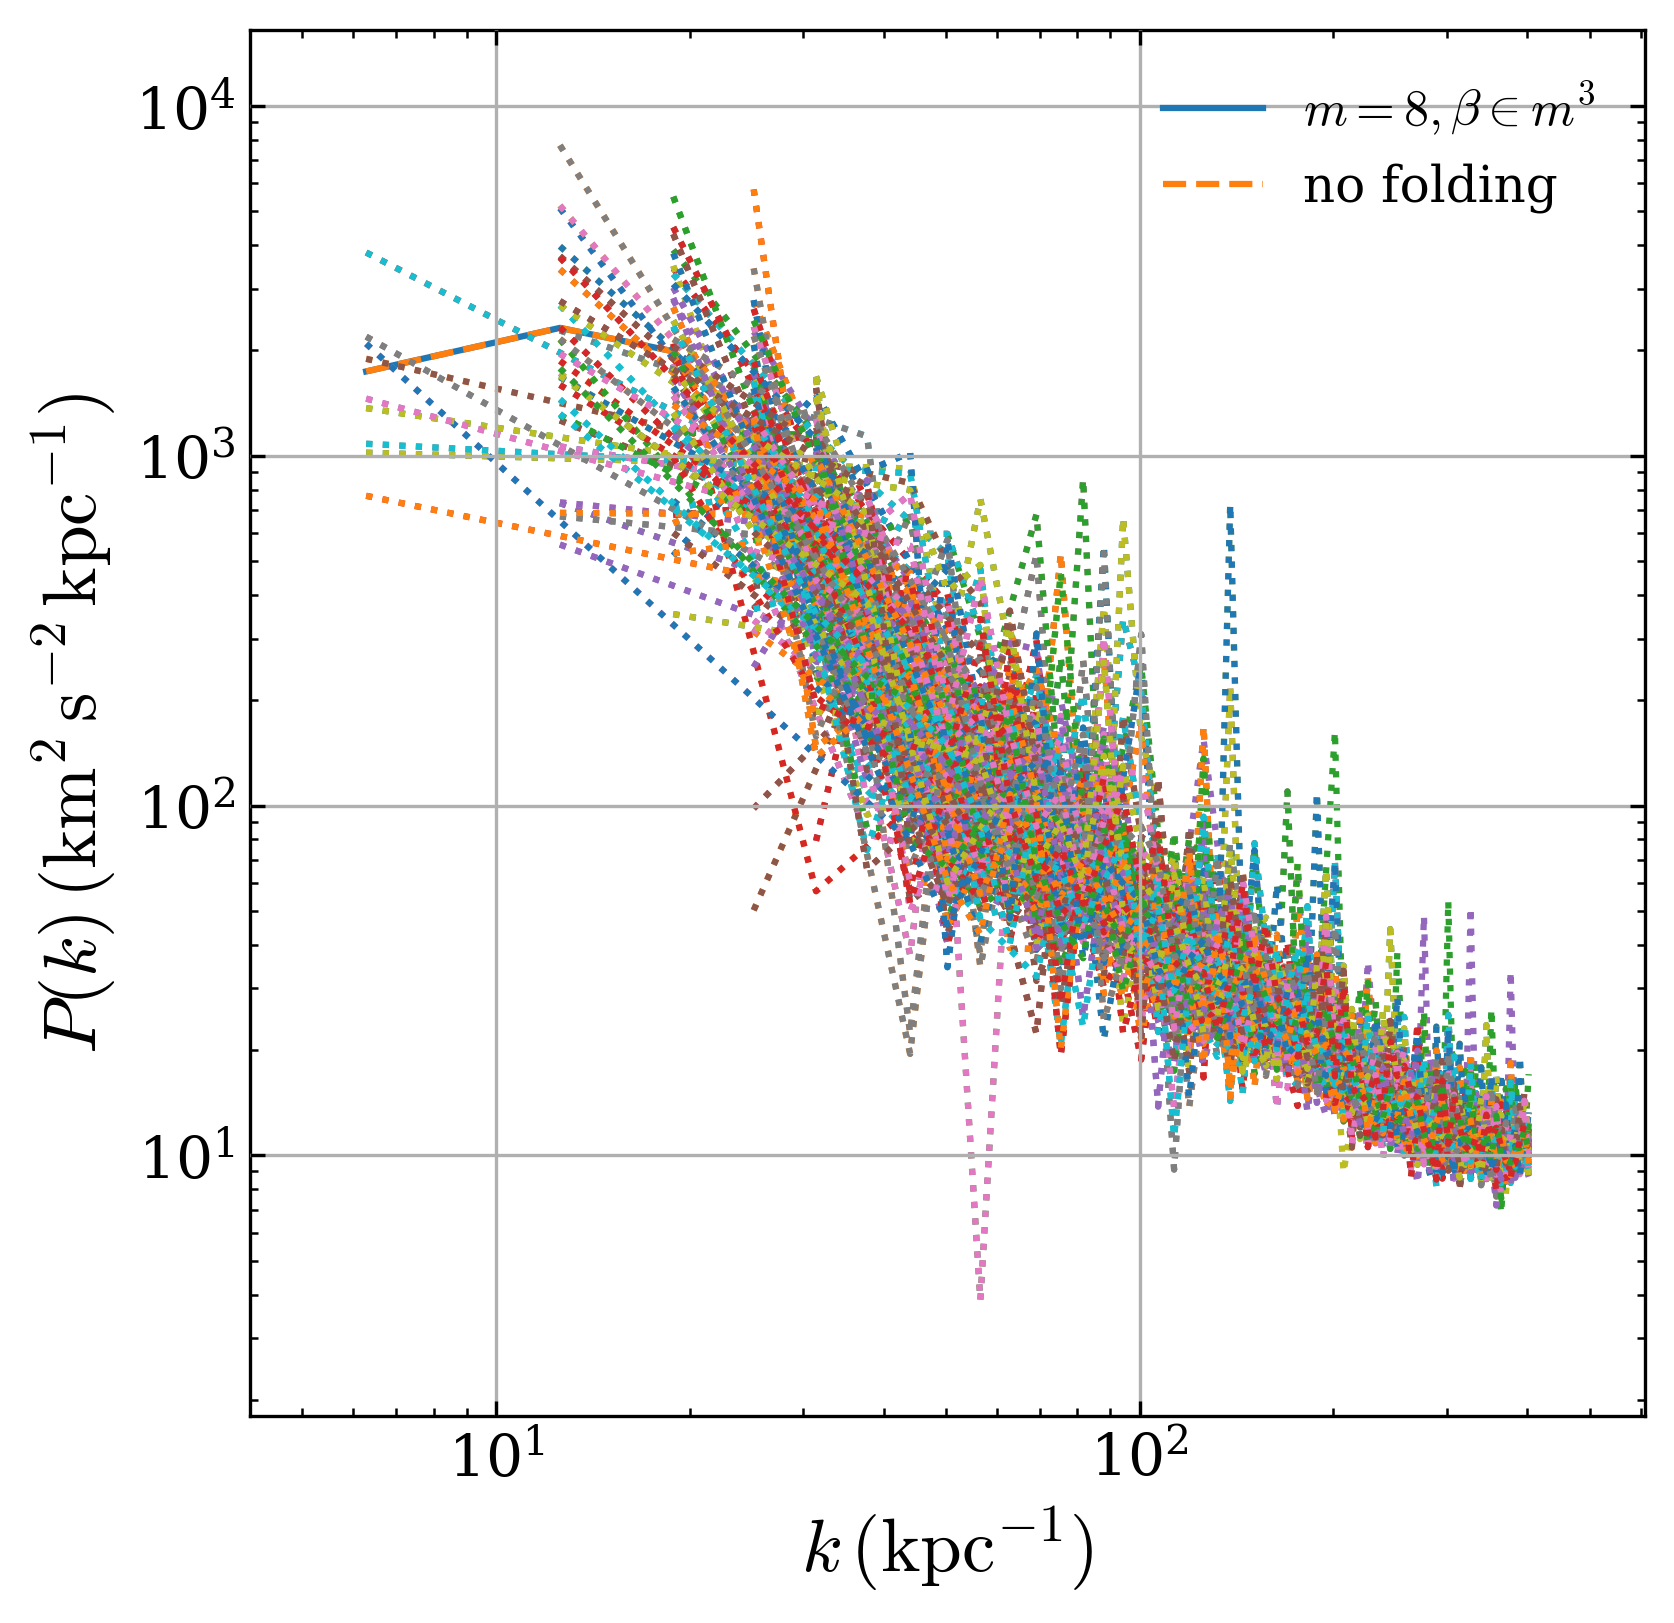

In [8]:
# Visualize the total m^3 space
fig, ax = plt.subplots()
fullspctrm.plot(ax=ax, label='$m={}, \\beta\\in m^3$'.format(m))
spctrm0.plot(ax=ax, label='no folding', linestyle='dashed')
i = 0
for bi in range(m):
  for bj in range(m):
    for bk in range(m):
      spctrms[i].plot(ax=ax, linestyle='dotted')
      i += 1
plt.legend()
plt.show()

In [9]:
# -1. Run through all the m^3 space
bi = np.arange(0, m, 1)
bj = np.arange(0, m, 1)
bk = np.arange(0, m, 1)
beta_sequence = np.array(np.meshgrid(bi, bj, bk, indexing='ij')).T.reshape(-1,3)
print(beta_sequence.shape)

(512, 3)


In [10]:
# -1.0 By default order
# Combine spectra for the full beta space and measure the difference
diffs_default = []
full = empty_spectrum_like(spctrm0)
for beta in beta_sequence:
  for spctrm in spctrms:
    if (spctrm.header['beta'] == beta).all():
      full.add(spctrm)
      diff = relative_diff(spctrm0, full, mode='max')
      diffs_default.append(diff)
      break

/appalachia/d6/yujie/Test_PowerSpec/utils_spctrm.py:81: RuntimeWarning: invalid value encountered in true_divide
  self.P = self.Psum / self.Nsample * (4*np.pi*self.k**2)


In [11]:
# Cover the m^3 space in different order. Cause it matters.
def morton3d(x, y, z): # By ChatGPT
  # Interleave the bits of x, y, and z to produce a Morton index
  x = (x | (x << 16)) & 0x0000FFFF
  y = (y | (y << 16)) & 0x0000FFFF
  z = (z | (z << 16)) & 0x0000FFFF
  x = (x | (y << 8)) & 0x00FF00FF
  z = (z | (y << 8)) & 0x00FF00FF
  x = (x | (z << 4)) & 0x0F0F0F0F
  return (x | (z << 2) | (y << 1))

In [12]:
def hilbert3d(x, y, z, s):
  # Compute the Hilbert index for the given 3D point and side length s
  if s == 1:
    return 0
  else:
    s2 = s // 2
    xp, yp, zp = x // s2, y // s2, z // s2
    a = x % s2
    b = y % s2
    c = z % s2
    if xp == 0 and yp == 0 and zp == 0:
      return hilbert3d(a, b, c, s2) + 0 * s2 * s2 + 0 * s2 + 0
    elif xp == 0 and yp == 0 and zp == 1:
      return hilbert3d(s2 - 1 - c, s2 - 1 - b, a, s2) + 0 * s2 * s2 + 0 * s2 + 1
    elif xp == 0 and yp == 1 and zp == 0:
      return hilbert3d(a, s2 - 1 - c, s2 - 1 - b, s2) + 0 * s2 * s2 + 1 * s2 + 1
    elif xp == 0 and yp == 1 and zp == 1:
      return hilbert3d(a, b, c, s2) + 0 * s2 * s2 + 1 * s2 + 2
    elif xp == 1 and yp == 0 and zp == 0:
      return hilbert3d(b, a, c, s2) + 1 * s2 * s2 + 1 * s2 + 2
    elif xp == 1 and yp == 0 and zp == 1:
      return hilbert3d(s2 - 1 - b, a, s2 - 1 - c, s2) + 1 * s2 * s2 + 0 * s2 + 3
    elif xp == 1 and yp == 1 and zp == 0:
      return hilbert3d(s2 - 1 - c, b, s2 - 1 - a, s2) + 1 * s2 * s2 + 1 * s2 + 1
    elif xp == 1 and yp == 1 and zp == 1:
      return hilbert3d(s2 - 1 - c, s2 - 1 - a, b, s2) + 1 * s2 * s2 + 0 * s2 + 0


In [13]:
# -1.1 Sort the bspace array by Morton index
# Compute Morton indices for each beta
morton_indices = np.array([morton3d(i, j, k) for i, j, k in beta_sequence])
idx = np.argsort(morton_indices)
bspace_morton = beta_sequence[idx]
# Combine spectra for the full beta space and measure the difference
diffs_morton = []
full = empty_spectrum_like(spctrm0)
for beta in bspace_morton:
  for spctrm in spctrms:
    if (spctrm.header['beta'] == beta).all():
      full.add(spctrm)
      diff = relative_diff(spctrm0, full, mode='max')
      diffs_morton.append(diff)
      break

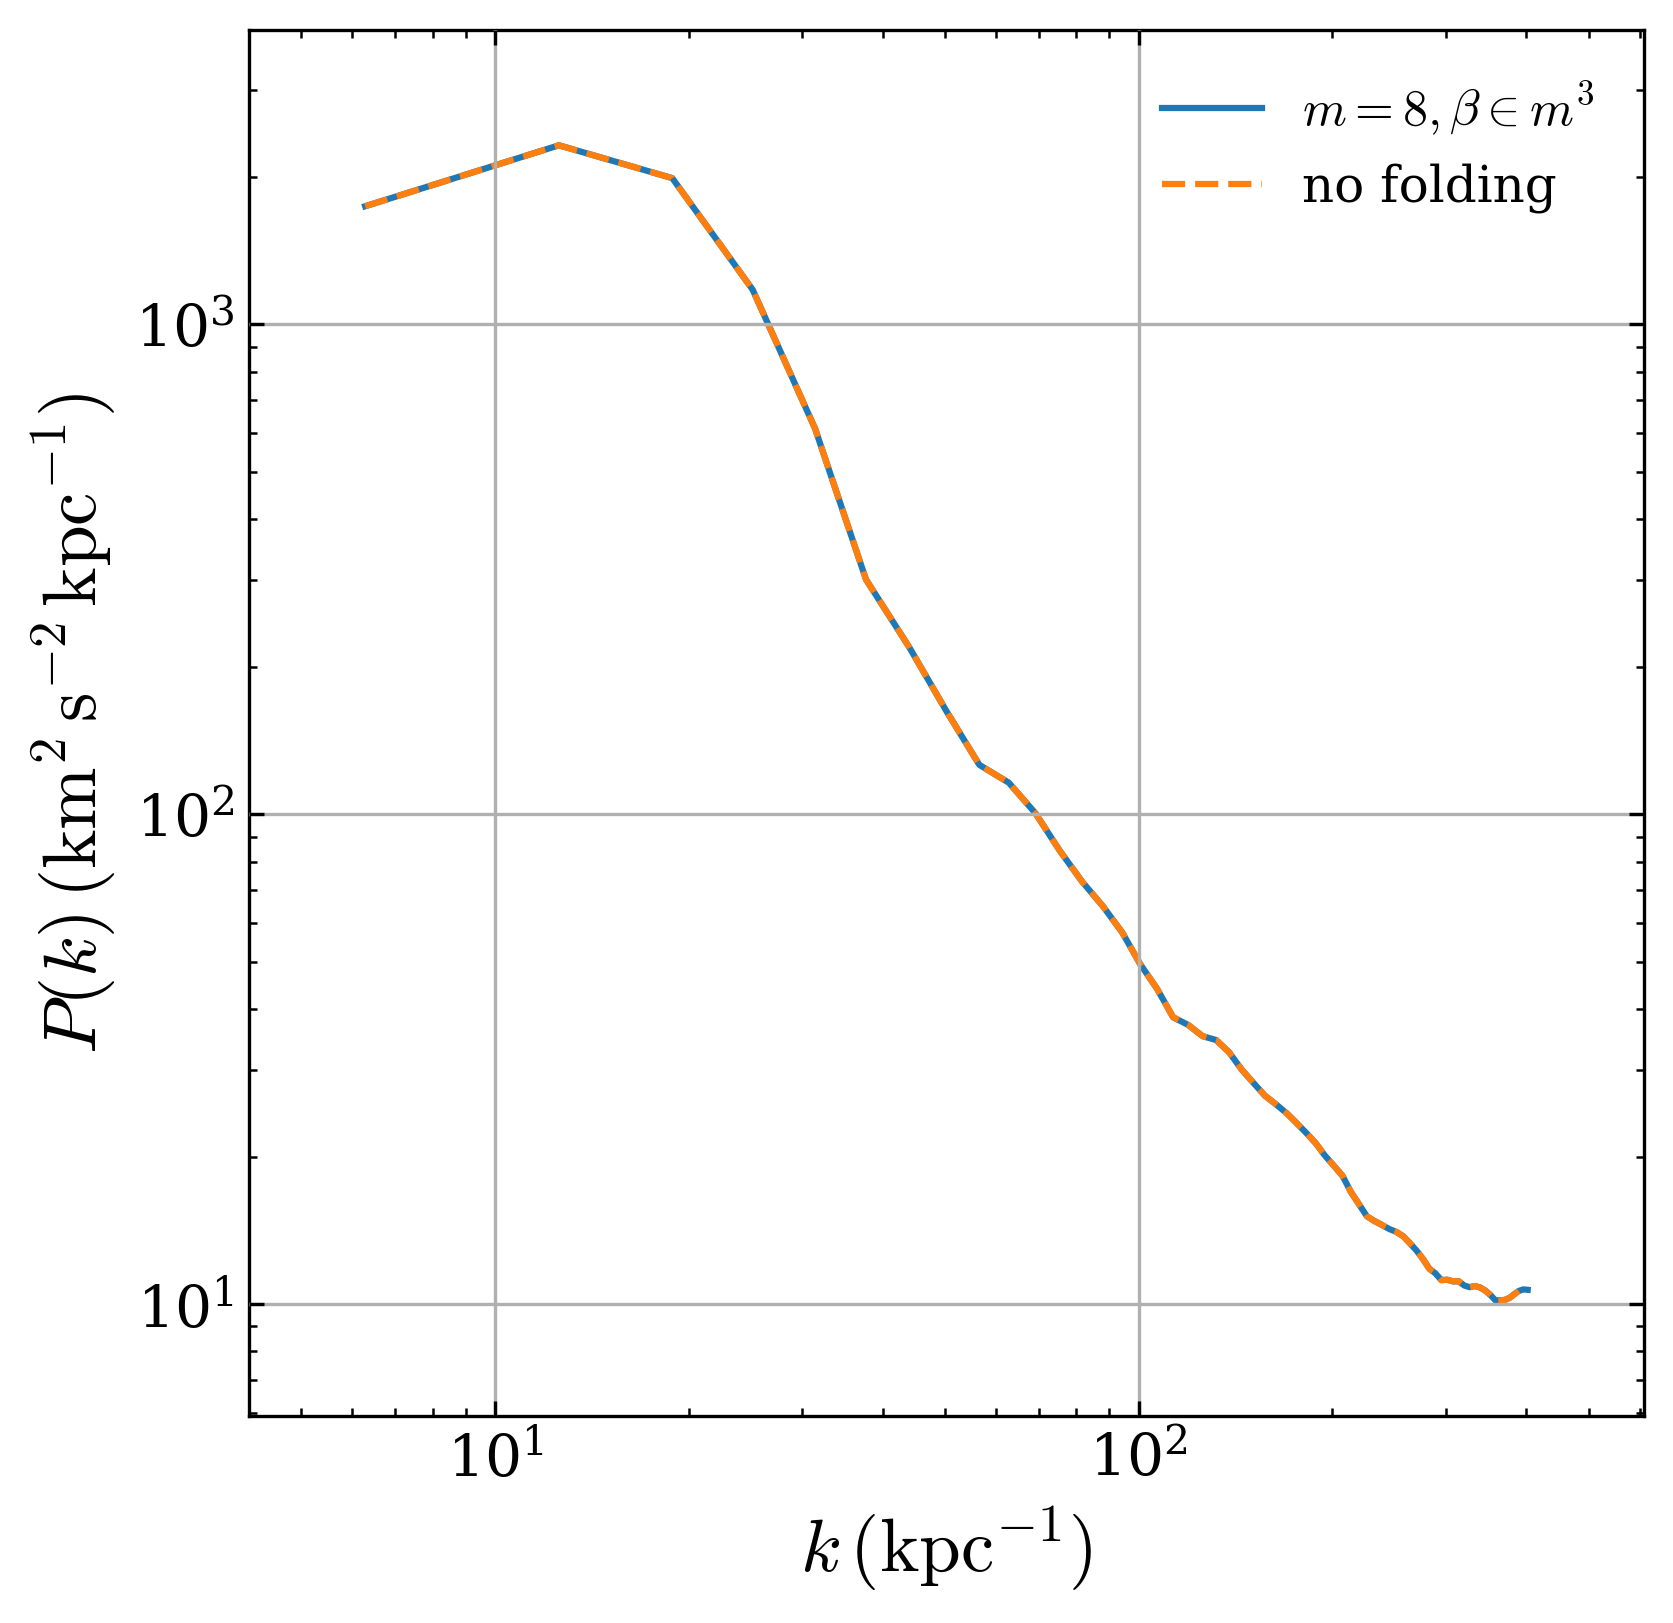

In [14]:
# Compare the full spectrum retored with the no folding case before
# running other tests.
fig, ax = plt.subplots()
full.plot(ax=ax, label='$m={}, \\beta\\in m^3$'.format(m))
spctrm0.plot(ax=ax, label='no folding', linestyle='dashed')
plt.legend()
plt.show()

In [15]:
# -1.2 Sort the bspace array by Hilbert index
# Compute the Hilbert indices for each beta
hilbert_indices = np.array([hilbert3d(i, j, k, m) for i, j, k in beta_sequence])
idx = np.argsort(hilbert_indices)
bspace_hilbert = beta_sequence[idx]
# Combine spectra for the full beta space and measure the difference
diffs_hilbert = []
full = empty_spectrum_like(spctrm0)
for beta in bspace_hilbert:
  for spctrm in spctrms:
    if (spctrm.header['beta'] == beta).all():
      full.add(spctrm)
      diff = relative_diff(spctrm0, full, mode='max')
      diffs_hilbert.append(diff)
      break

/appalachia/d6/yujie/Test_PowerSpec/utils_spctrm.py:81: RuntimeWarning: invalid value encountered in true_divide
  self.P = self.Psum / self.Nsample * (4*np.pi*self.k**2)


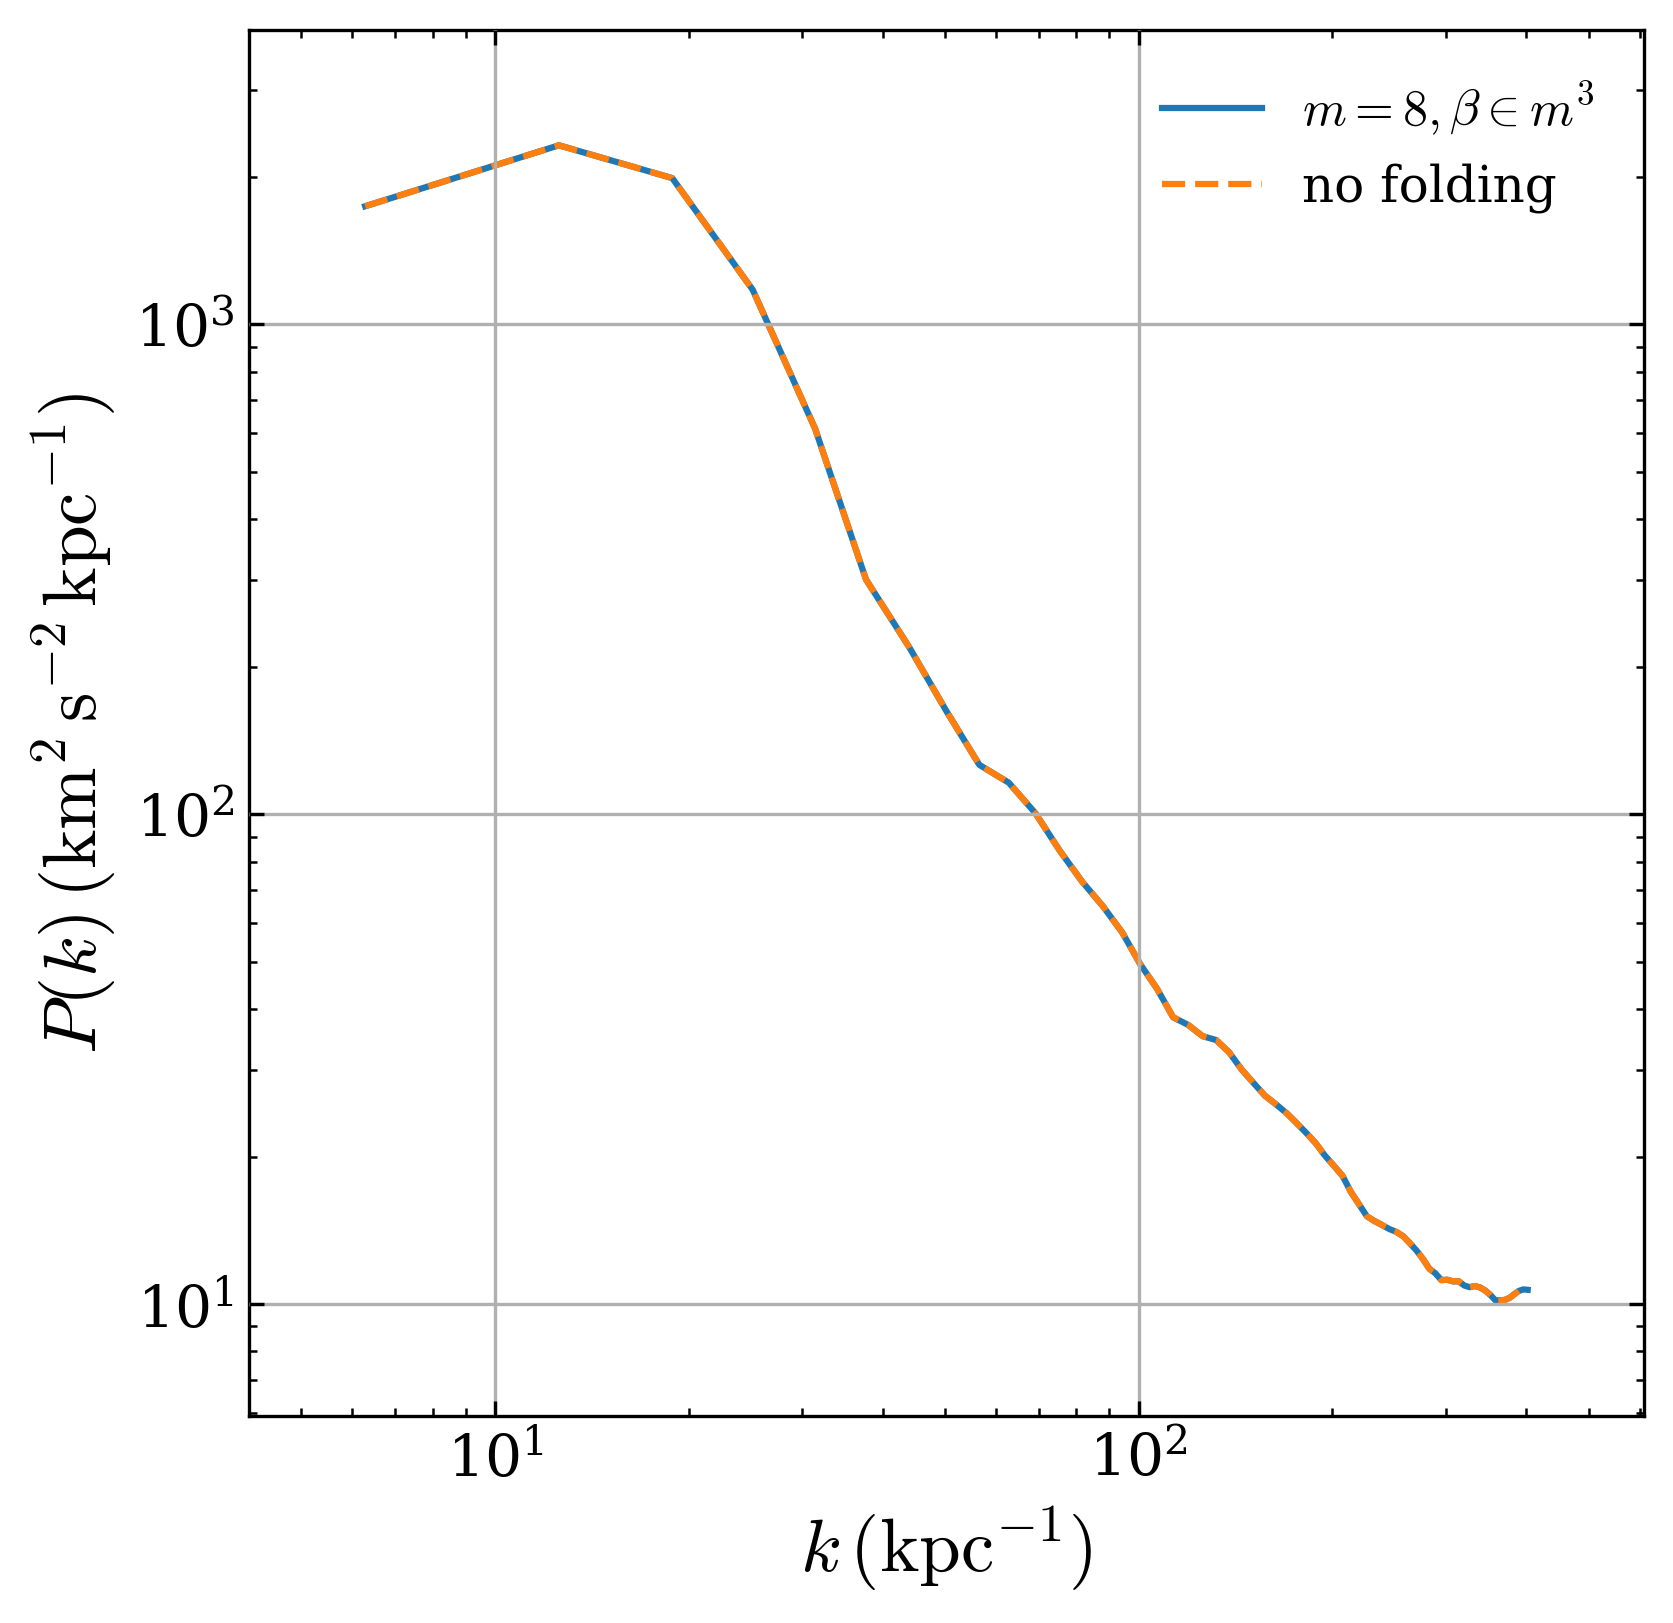

In [16]:
# Compare the full spectrum retored with the no folding case before
# running other tests.
fig, ax = plt.subplots()
full.plot(ax=ax, label='$m={}, \\beta\\in m^3$'.format(m))
spctrm0.plot(ax=ax, label='no folding', linestyle='dashed')
plt.legend()
plt.show()

In [28]:
# -1.3 Randomly shuffle the bspace array
np.random.seed(1)
bspace_random = np.random.permutation(beta_sequence)

# Combine spectra for the full beta space and measure the difference
diffs_random = []
full = empty_spectrum_like(spctrm0)
for beta in bspace_random:
  for spctrm in spctrms:
    if (spctrm.header['beta'] == beta).all():
      full.add(spctrm)
      diff = relative_diff(spctrm0, full, mode='max')
      diffs_random.append(diff)
      break

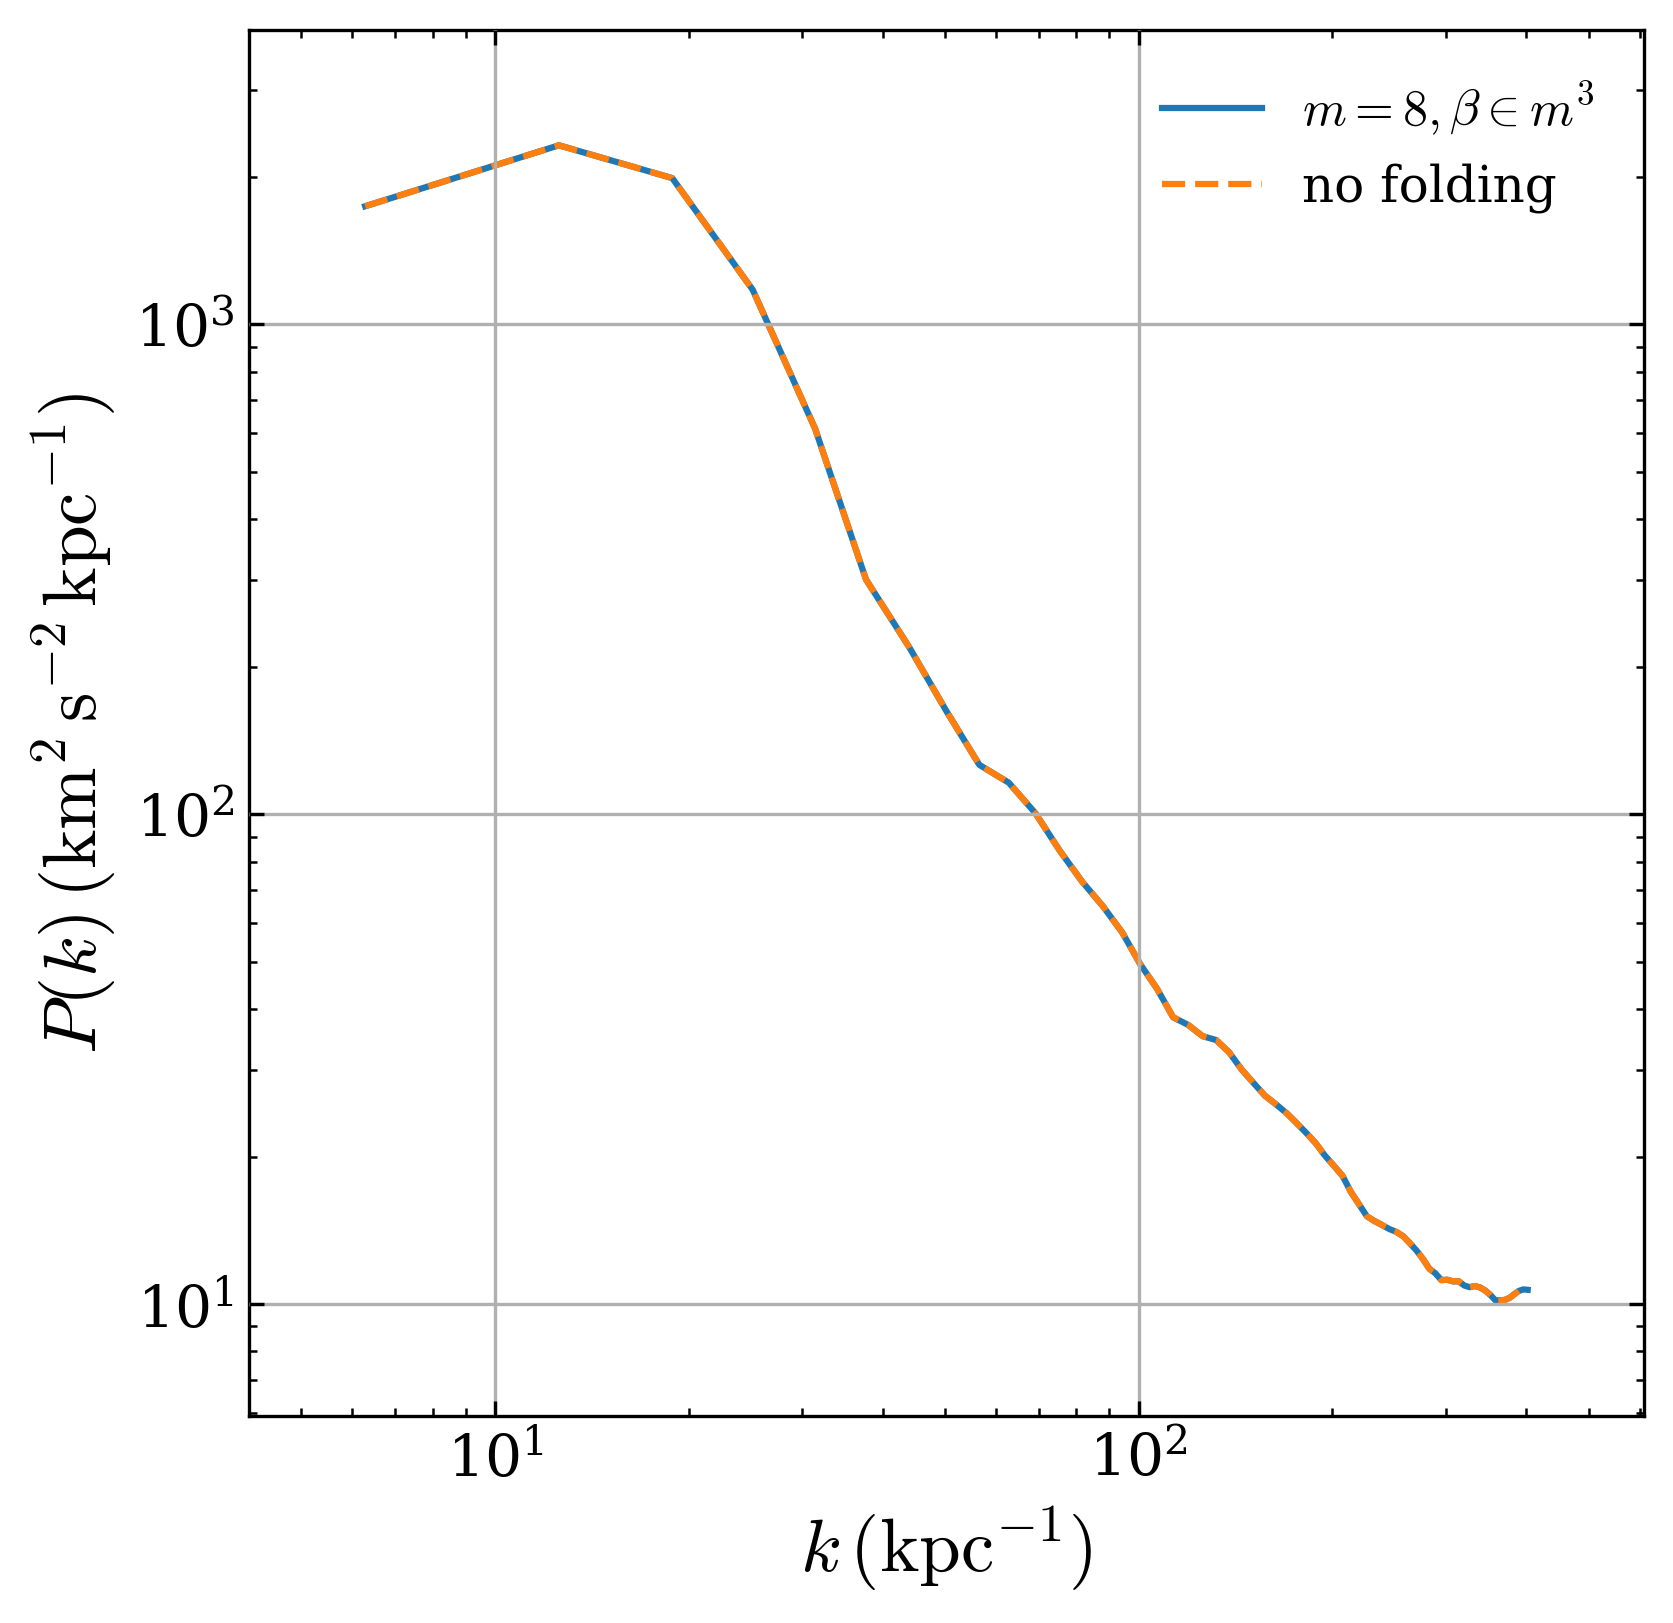

In [29]:
# Compare the full spectrum retored with the no folding case before
# running other tests.
fig, ax = plt.subplots()
full.plot(ax=ax, label='$m={}, \\beta\\in m^3$'.format(m))
spctrm0.plot(ax=ax, label='no folding', linestyle='dashed')
plt.legend()
plt.show()

In [30]:
# -1.4 Hilbert curve by levels
# Compute the beta sequence
bspace_hilbert_lv = hilbert_beta_sequence(m=m, randomize=True, seed=1)
# Combine spectra for the full beta space and measure the difference
diffs_hilbert_lv = []
full = empty_spectrum_like(spctrm0)
for beta in bspace_hilbert_lv:
  for spctrm in spctrms:
    if (spctrm.header['beta'] == beta).all():
      full.add(spctrm)
      diff = relative_diff(spctrm0, full, mode='max')
      diffs_hilbert_lv.append(diff)
      break

/appalachia/d6/yujie/Test_PowerSpec/utils_spctrm.py:81: RuntimeWarning: invalid value encountered in true_divide
  self.P = self.Psum / self.Nsample * (4*np.pi*self.k**2)


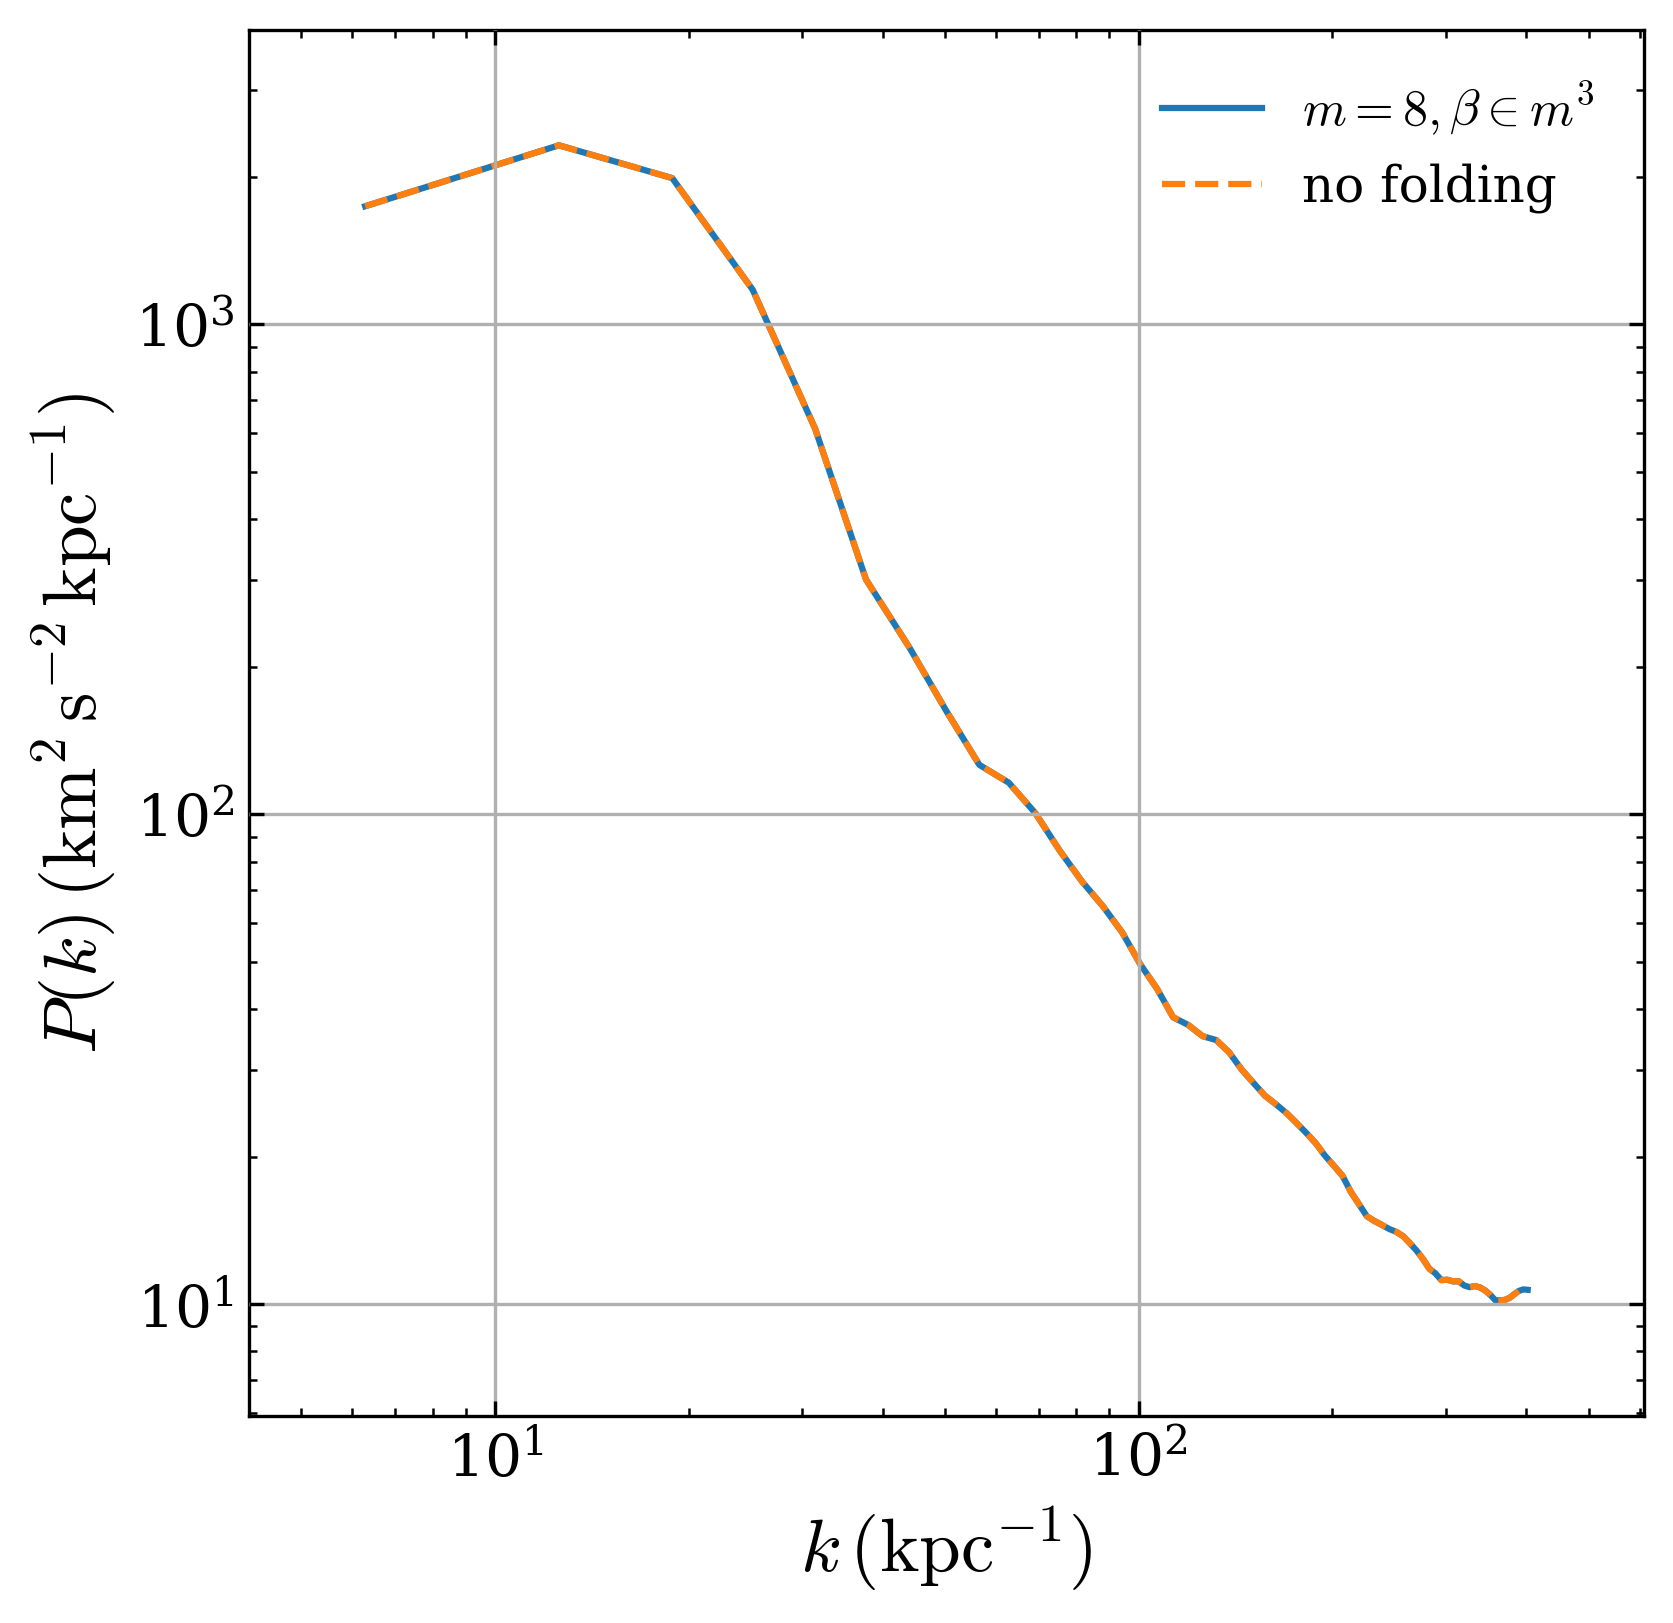

In [31]:
# Compare the full spectrum retored with the no folding case before
# running other tests.
fig, ax = plt.subplots()
full.plot(ax=ax, label='$m={}, \\beta\\in m^3$'.format(m))
spctrm0.plot(ax=ax, label='no folding', linestyle='dashed')
plt.legend()
plt.show()

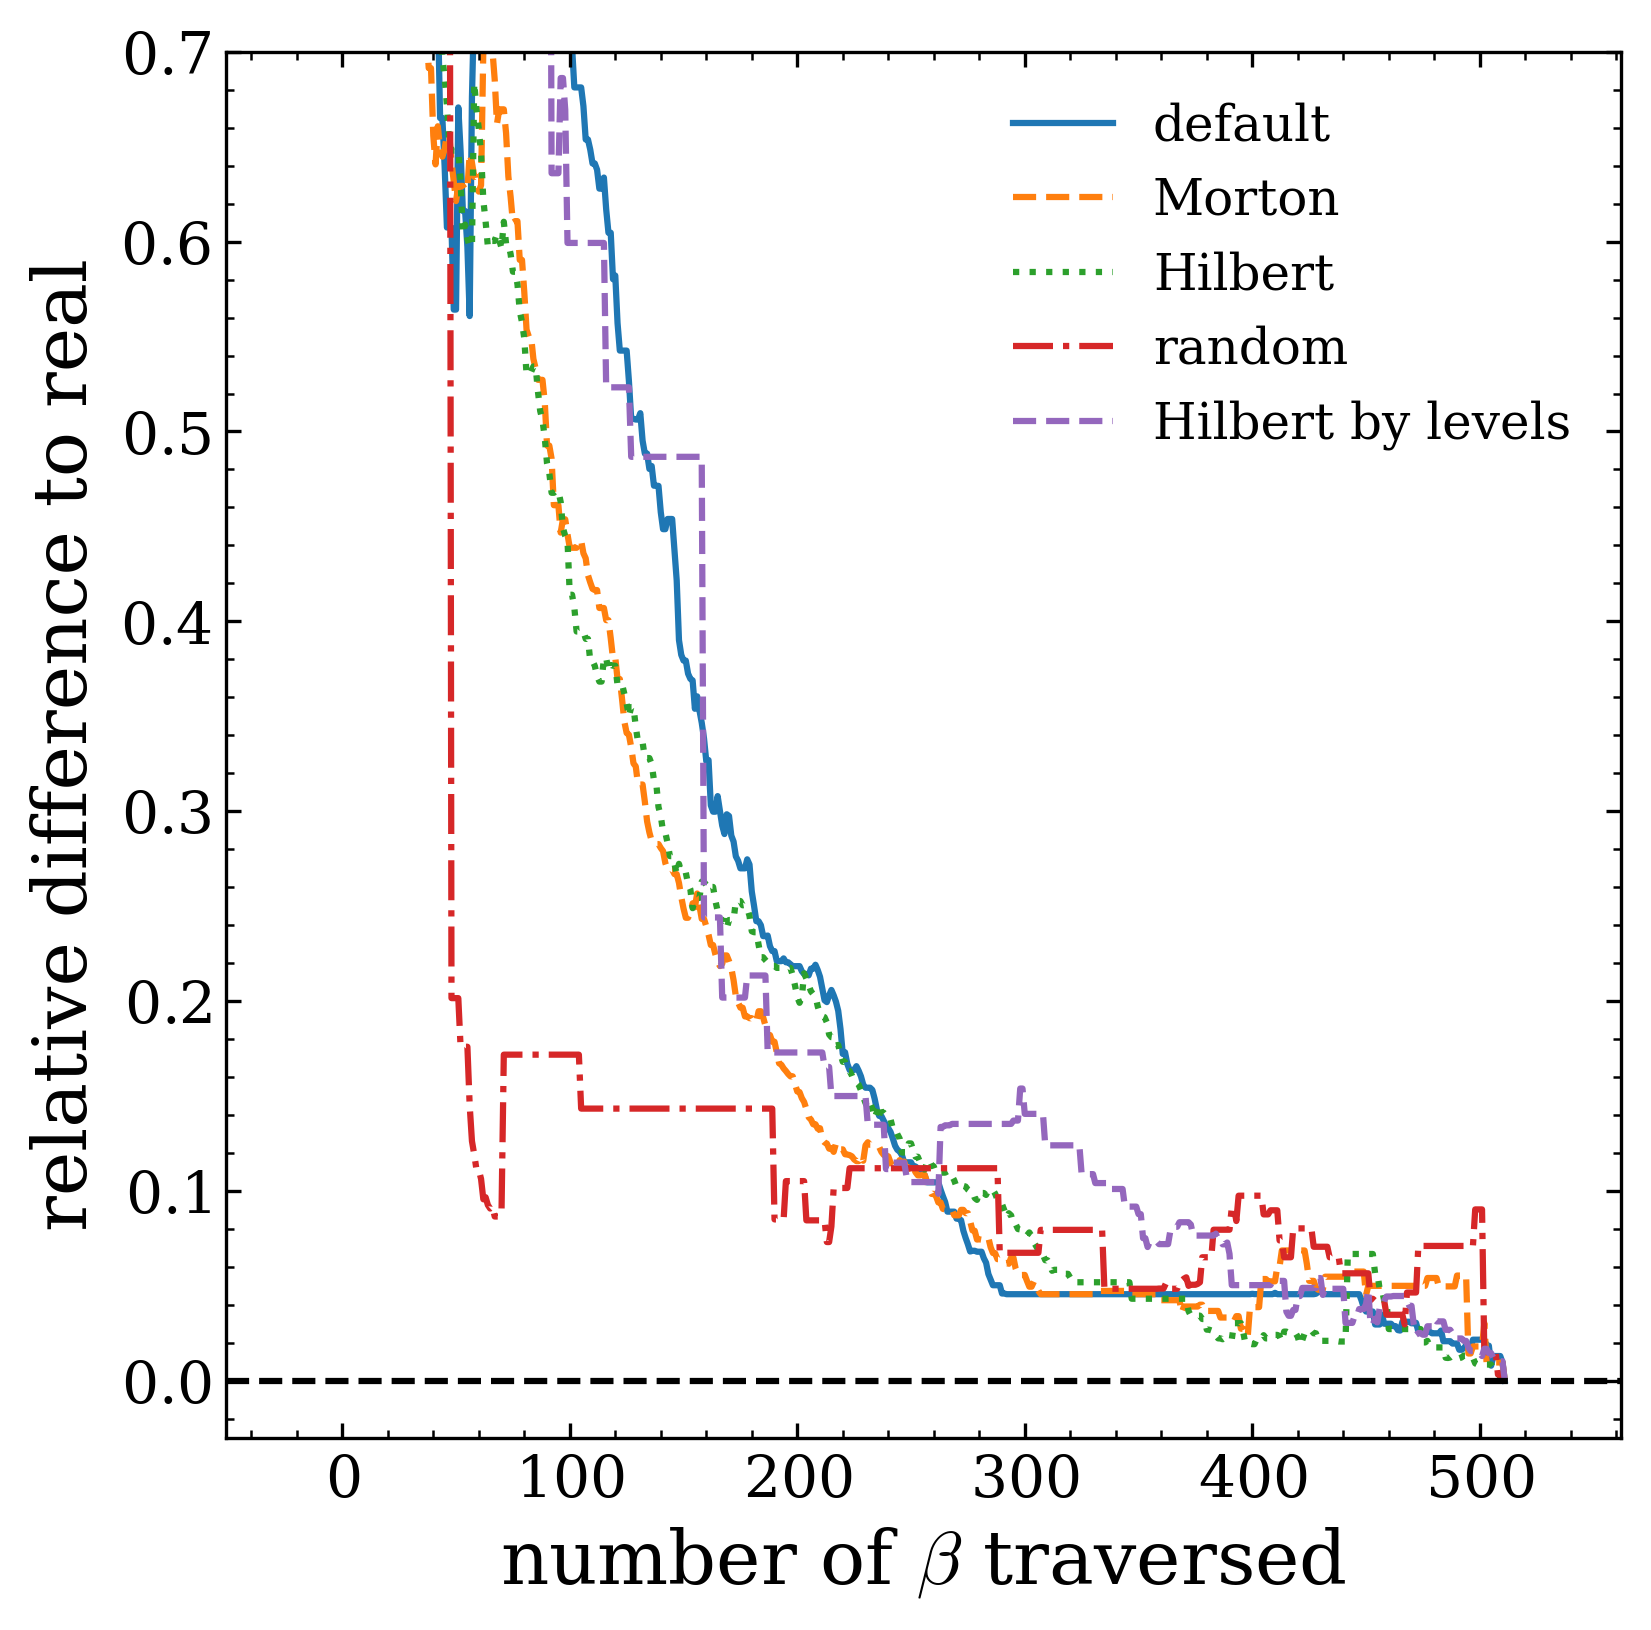

In [32]:
# -1.-3 Plot the differences
plt.plot(diffs_default, label='default')
plt.plot(diffs_morton, label='Morton', linestyle='dashed')
plt.plot(diffs_hilbert, label='Hilbert', linestyle='dotted')
plt.plot(diffs_random, label='random', linestyle='dashdot')
plt.plot(diffs_hilbert_lv, label='Hilbert by levels', linestyle='dashed')
plt.axhline(0, color='k', linestyle='dashed')
plt.ylabel('relative difference to real')
plt.xlabel('number of $\\beta$ traversed')
plt.ylim(-0.03, 0.7)
# plt.xlim(5, 150)
plt.legend()
plt.show()

In [33]:
# -1.-1 Difference on the fly
# Combine spectra for the full beta space and measure the difference
diffs_random_fly = []
part = empty_spectrum_like(spctrm0)
for beta in bspace_random:
  for spctrm in spctrms:
    if (spctrm.header['beta'] == beta).all():
      part0 = part.copy()
      part.add(spctrm)
      diff = relative_diff(part0, part, mode='mean')
      diffs_random_fly.append(diff)
      break
  if diff < 1e-3: # stop when the difference is small enough # type: ignore
    break

/appalachia/d6/yujie/Test_PowerSpec/utils_spctrm.py:81: RuntimeWarning: invalid value encountered in true_divide
  self.P = self.Psum / self.Nsample * (4*np.pi*self.k**2)


(-4.0, 1.0)

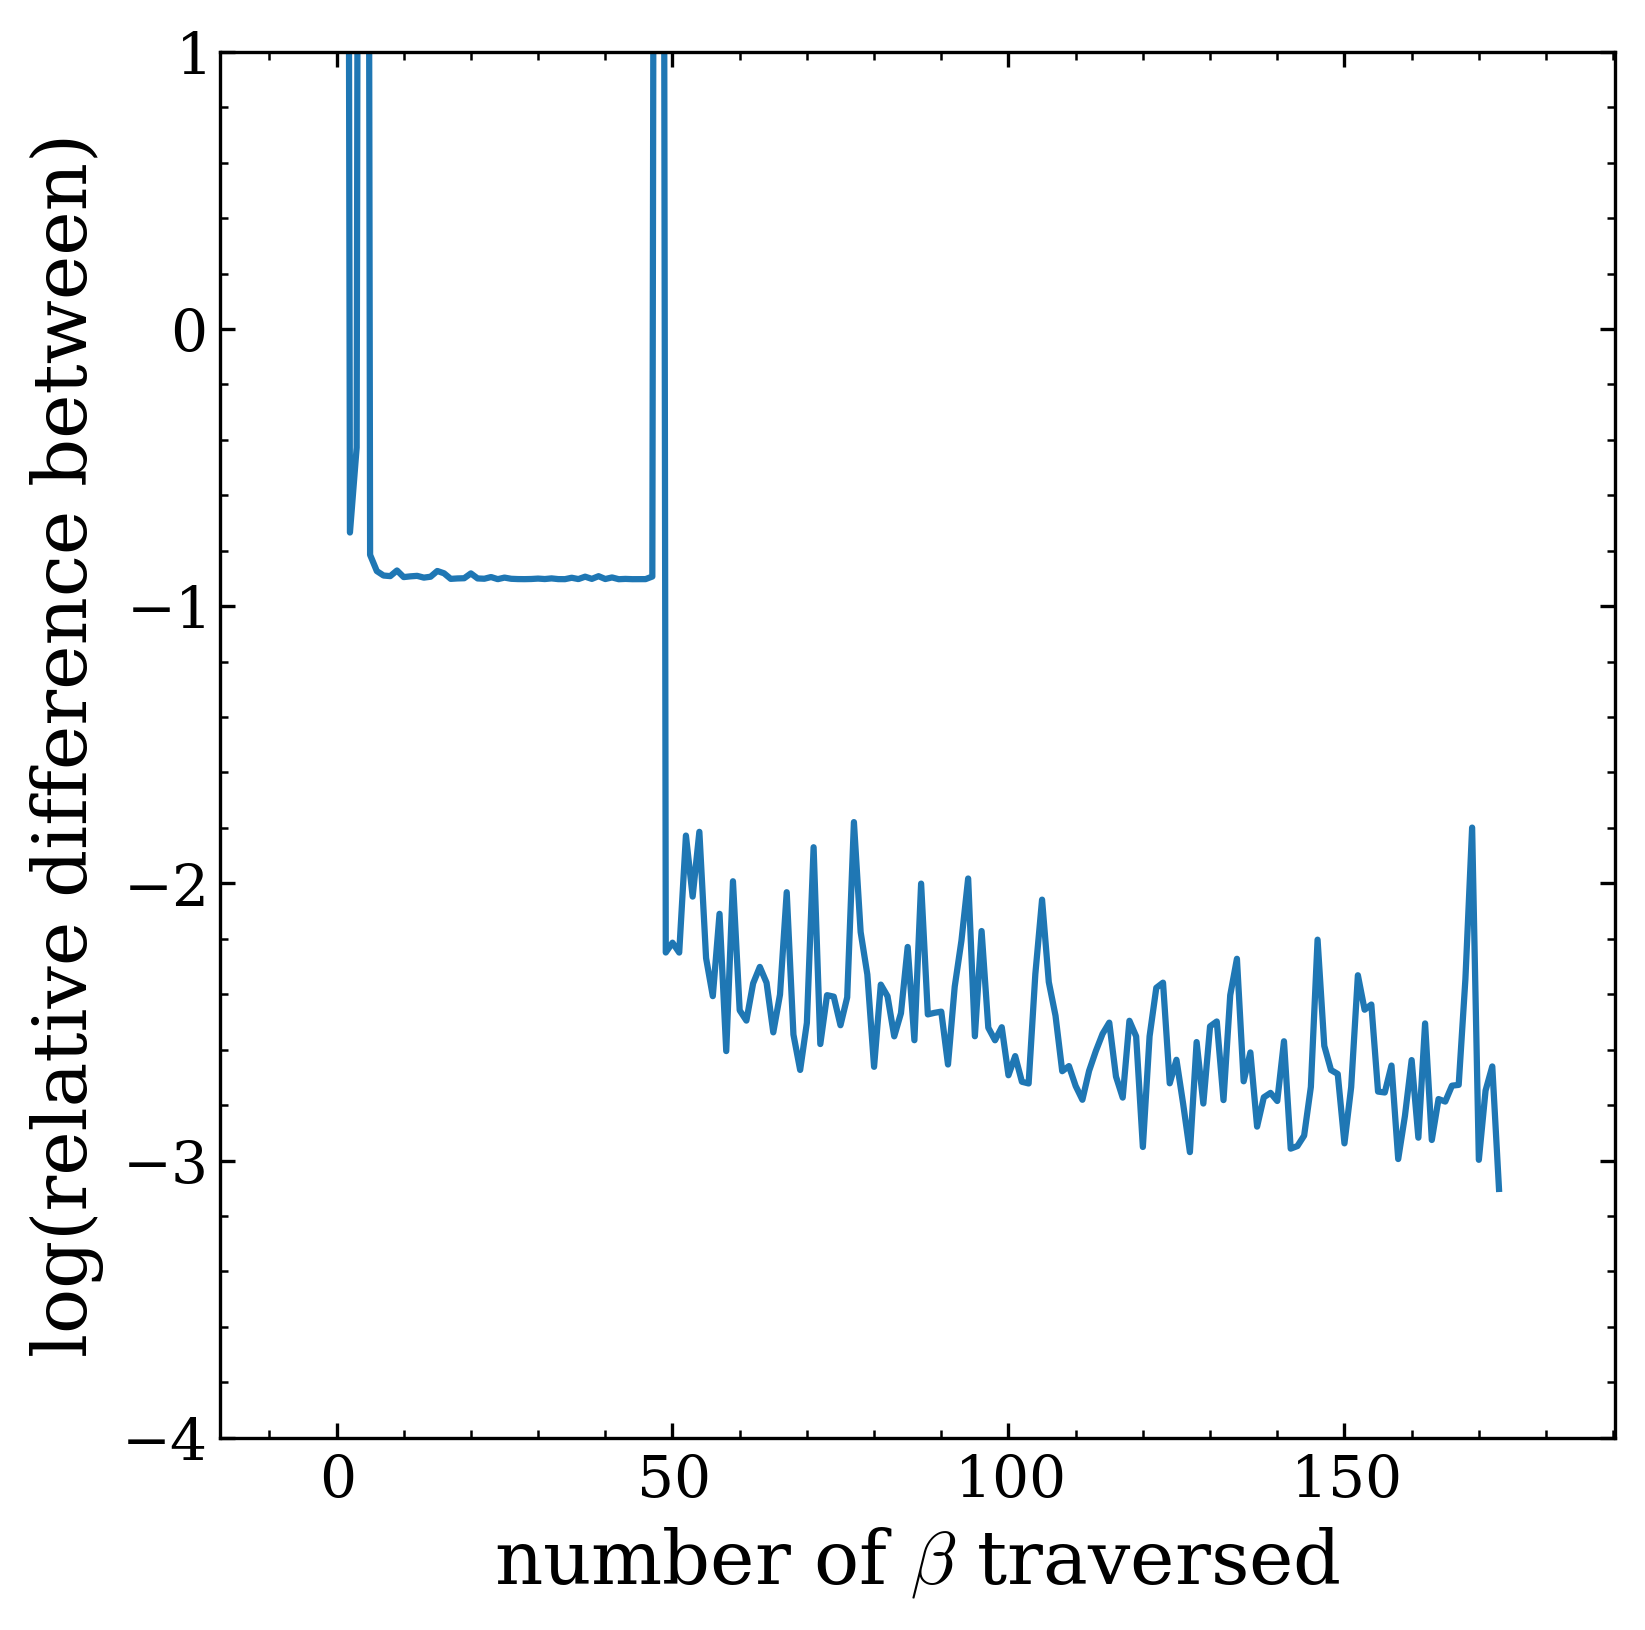

In [35]:
plt.plot(np.log10(diffs_random_fly))
plt.ylabel('log(relative difference between)')
plt.xlabel('number of $\\beta$ traversed')
plt.ylim(-4, 1)

In [42]:
print(diffs_random_fly[49], len(diffs_random_fly))

0.00563014770159576 174


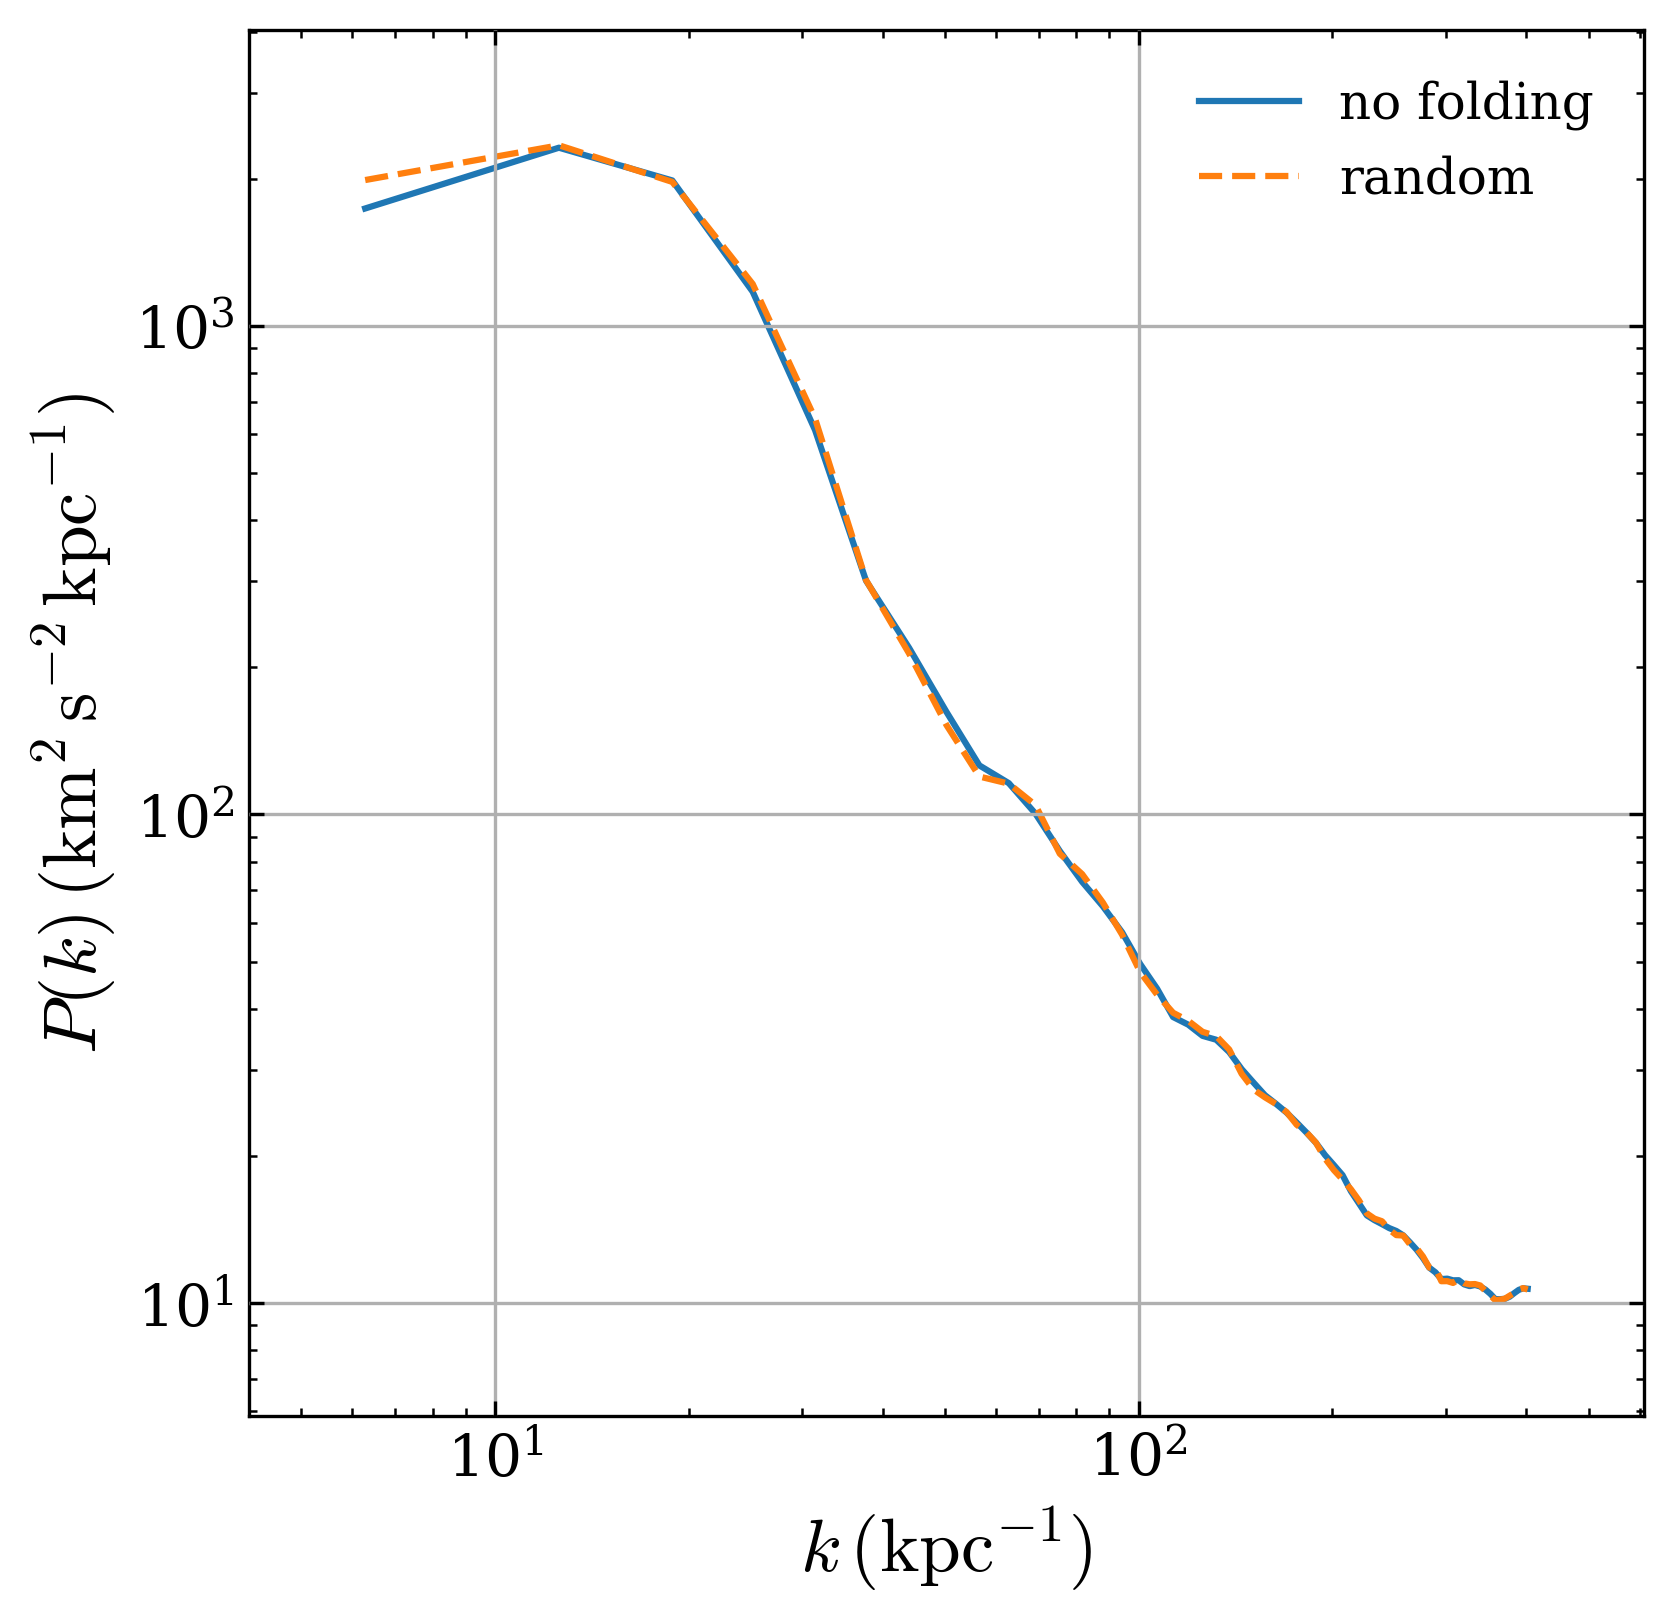

In [37]:
# Compare the down sampled spectrum retored with the no folding case
fig, ax = plt.subplots()
spctrm0.plot(ax=ax, label='no folding')
part.plot(ax=ax, label='random', linestyle='dashed')
plt.legend()
plt.show()